In [45]:
# Load the DataFrame from Parquet
import pandas as pd

df_all = pd.read_parquet("/kaggle/input/parquet-df-audit-opinions")
print("Loaded DataFrame with shape:", df_all.shape)

Loaded DataFrame with shape: (77586, 6)


In [2]:
# Set max rows to 500 so full output shows
pd.set_option("display.max_rows", 3000)

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report,  confusion_matrix

from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
import numpy as np

In [4]:
# Load your combined dataframe (df_all) here, with columns: ['year', 'text', 'label', 'source', 'llm']

# Filter only relevant years for training/testing
df_all = df_all[(df_all['year'] >= 1998) & (df_all['year'] <= 2021)].reset_index(drop=True)

In [5]:
df_all

,year,firm_id,text,label,source,llm
0,2020,884940,Report of Independent Registered Public Accoun...,1,original,None
1,2020,1648428,REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUN...,1,original,None
2,2020,1109189,Report of Independent Registered Public Accoun...,1,original,None
3,2020,1211351,REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUN...,1,original,None
4,2020,1166126,REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUN...,1,original,None
...,...,...,...,...,...,...
77581,2001,1077552,We have conducted an extensive review of the c...,1,paraphrased,deepseek_all_paraphrased
77582,2001,1043055,REPORT OF INDEPENDENT AUDITORS\n\nThe Board of...,1,paraphrased,deepseek_all_paraphrased
77583,2001,1043055,The Board of Directors and Shareholders of Lei...,1,paraphrased,deepseek_all_paraphrased
77584,2001,1043055,We have reviewed the consolidated balance shee...,1,paraphrased,deepseek_all_paraphrased


In [6]:
df_all[df_all['source']=='original']

,year,firm_id,text,label,source,llm
0,2020,884940,Report of Independent Registered Public Accoun...,1,original,None
1,2020,1648428,REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUN...,1,original,None
2,2020,1109189,Report of Independent Registered Public Accoun...,1,original,None
3,2020,1211351,REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUN...,1,original,None
4,2020,1166126,REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUN...,1,original,None
...,...,...,...,...,...,...
68213,2000,948976,To the Shareholders and Board of Directors o...,0,original,None
68214,2000,929649,REPORT OF INDEPENDENT AUDITORS<p> Board of Di...,0,original,None
68215,2000,765258,INDEPENDENT AUDITORS' REPORT<p>THE BOARD OF DI...,0,original,None
68216,2000,350403,Independent Auditors' Report<p>To the Board of...,0,original,None


In [7]:
df_all.describe()

,year,label
count,77586.000000,77586.000000
mean,2009.374217,0.127781
std,6.386803,0.333848
min,1998.000000,0.000000
25%,2004.000000,0.000000
50%,2009.000000,0.000000
75%,2015.000000,0.000000
max,2021.000000,1.000000


## LOAD PREDICTIONS 1S

In [8]:
file_path = "/kaggle/input/df-predicted-1s/df_predicted_1s.pkl"

try:
    df_1s_best = pd.read_pickle(file_path)
    print("DataFrame no1 loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file at {file_path} was not found.")

file_path = "/kaggle/input/df-predicted-1s/df_predicted_1s_2nd_best.pkl"

try:
    df_1s_2nd_best = pd.read_pickle(file_path)
    print("DataFrame no2 loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file at {file_path} was not found.")

file_path = "/kaggle/input/df-predicted-1s/df_predicted_1s_3rd_best.pkl"

try:
    df_1s_3rd_best = pd.read_pickle(file_path)
    print("DataFrame no3 loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file at {file_path} was not found.")

file_path = "/kaggle/input/df-predicted-1s/df_predicted_1s_4th_best.pkl"

try:
    df_1s_4th_best = pd.read_pickle(file_path)
    print("DataFrame no4 loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file at {file_path} was not found.")


DataFrame no1 loaded successfully!
DataFrame no2 loaded successfully!
DataFrame no3 loaded successfully!
DataFrame no4 loaded successfully!


In [9]:
df_1s_best.describe()

,year,true_label
count,666.000000,666.000000
mean,2009.642643,0.192192
std,6.467146,0.394319
min,2000.000000,0.000000
25%,2004.000000,0.000000
50%,2009.000000,0.000000
75%,2016.000000,0.000000
max,2021.000000,1.000000


In [10]:
df_1s_2nd_best.describe()

,year,true_label,pred_label,score
count,787.000000,787.000000,787.0,787.000000
mean,2007.096569,0.160102,1.0,0.489298
std,6.893285,0.366933,0.0,0.143168
min,2000.000000,0.000000,1.0,0.272171
25%,2001.000000,0.000000,1.0,0.359769
50%,2004.000000,0.000000,1.0,0.467537
75%,2012.000000,0.000000,1.0,0.604317
max,2021.000000,1.000000,1.0,0.864817


In [11]:
df_1s_3rd_best.describe()

,year,true_label,pred_score,used_threshold
count,1177.000000,1177.000000,1177.000000,1177.000000
mean,2014.396771,0.078165,0.663497,0.401121
std,7.367521,0.268545,0.212327,0.112074
min,2000.000000,0.000000,0.202669,0.200000
25%,2010.000000,0.000000,0.493122,0.410000
50%,2019.000000,0.000000,0.661667,0.410000
75%,2019.000000,0.000000,0.850962,0.410000
max,2021.000000,1.000000,0.996727,0.910000


In [12]:
df_1s_4th_best.describe()

,year,true_label,pred_score,used_threshold
count,1082.000000,1082.000000,1082.000000,1082.000000
mean,2015.541590,0.067468,0.606657,0.360767
std,6.348835,0.250946,0.208607,0.115191
min,2000.000000,0.000000,0.200144,0.200000
25%,2016.000000,0.000000,0.431837,0.340000
50%,2019.000000,0.000000,0.586290,0.340000
75%,2019.000000,0.000000,0.773560,0.340000
max,2021.000000,1.000000,0.993238,0.970000


In [13]:
def unify_strategies(df_1s_best, df_1s_2nd_best, df_1s_3rd_best,df_1s_4th_best):
    # Add prediction markers
    df_1s_best = df_1s_best.assign(pred_best=1, pred_2nd=0, pred_3rd=0,pred_4th=0)
    df_1s_2nd_best = df_1s_2nd_best.assign(pred_best=0, pred_2nd=1, pred_3rd=0,pred_4th=0)
    df_1s_3rd_best = df_1s_3rd_best.assign(pred_best=0, pred_2nd=0, pred_3rd=1,pred_4th=0)
    df_1s_4th_best = df_1s_4th_best.assign(pred_best=0, pred_2nd=0, pred_3rd=0,pred_4th=1)

    # Stack them together
    df_all = pd.concat([df_1s_best, df_1s_2nd_best, df_1s_3rd_best,df_1s_4th_best], ignore_index=True)

    # Group by unique year + firm_id, keeping text and true_label (should be consistent across dfs)
    # Aggregate prediction flags with max() (if any model predicted → 1)
    df_unified = (
        df_all.groupby(["year", "firm_id"], as_index=False)
        .agg({
            "text": "first",        # take the text (all should be the same)
            "true_label": "first",  # take the true label
            "pred_best": "max",
            "pred_2nd": "max",
            "pred_3rd": "max",
            "pred_4th": "max"
        })
    )

    return df_unified

# Example usage
df_unified = unify_strategies(df_1s_best, df_1s_2nd_best, df_1s_3rd_best,df_1s_4th_best)
df_unified.tail(100)

,year,firm_id,text,true_label,pred_best,pred_2nd,pred_3rd,pred_4th
1885,2019,921082,REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUN...,0,0,0,0,1
1886,2019,92122,REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUN...,0,0,0,1,1
1887,2019,921582,Report of Independent Registered Public Accoun...,0,0,0,1,1
1888,2019,921738,REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUN...,0,0,0,1,1
1889,2019,922224,REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUN...,0,0,0,1,1
1890,2019,92230,Report of Independent Registered Public Accoun...,0,0,0,1,0
1891,2019,922358,REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUN...,0,1,0,0,1
1892,2019,923120,Report of Independent Registered Public Accoun...,0,0,0,0,1
1893,2019,923139,Report of Independent Registered Public Accoun...,0,0,0,1,0
1894,2019,92380,Report of Independent Registered Public Accoun...,0,0,0,1,1


In [14]:
df_unified.describe()

,year,true_label,pred_best,pred_2nd,pred_3rd,pred_4th
count,1985.000000,1985.000000,1985.000000,1985.000000,1985.000000,1985.000000
mean,2012.216625,0.095214,0.335516,0.396474,0.592947,0.545088
std,7.635234,0.293584,0.472290,0.489288,0.491409,0.498088
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,2019.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,2021.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
df_unified[(df_unified['true_label']==1)].describe()

,year,true_label,pred_best,pred_2nd,pred_3rd,pred_4th
count,189.000000,189.0,189.000000,189.000000,189.000000,189.000000
mean,2007.952381,1.0,0.677249,0.666667,0.486772,0.386243
std,6.913051,0.0,0.468770,0.472657,0.501153,0.488181
min,2000.000000,1.0,0.000000,0.000000,0.000000,0.000000
25%,2001.000000,1.0,0.000000,0.000000,0.000000,0.000000
50%,2008.000000,1.0,1.000000,1.000000,0.000000,0.000000
75%,2015.000000,1.0,1.000000,1.000000,1.000000,1.000000
max,2020.000000,1.0,1.000000,1.000000,1.000000,1.000000


In [16]:
df_unified[(df_unified['year']==2018)]

,year,firm_id,text,true_label,pred_best,pred_2nd,pred_3rd,pred_4th
1030,2018,1159281,Report of Independent Registered Public Accoun...,0,1,0,1,0
1031,2018,1275229,Report of Independent Registered Public Accoun...,0,1,1,1,1
1032,2018,1282266,Report of Independent Registered Public Accoun...,0,1,0,1,0
1033,2018,13239,Report of Independent Registered Public Accoun...,0,1,0,1,0
1034,2018,1350381,Report of Independent Registered Public Accoun...,0,1,1,1,1
1035,2018,1356090,REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUN...,0,1,1,1,1
1036,2018,1400891,Report of Independent Registered Public Accoun...,0,0,0,1,0
1037,2018,1405073,REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUN...,1,1,1,1,1
1038,2018,1437106,Report of Independent Registered Public Accoun...,0,1,0,1,0
1039,2018,1441849,Report of Independent Registered Public Accoun...,1,1,0,0,0


In [17]:
df_unified[(df_unified['pred_best']==1)&(df_unified['pred_3rd']>0)].describe()

,year,true_label,pred_best,pred_2nd,pred_3rd,pred_4th
count,328.000000,328.000000,328.0,328.000000,328.0,328.000000
mean,2009.823171,0.216463,1.0,0.664634,1.0,0.664634
std,7.624952,0.412463,0.0,0.472840,0.0,0.472840
min,2000.000000,0.000000,1.0,0.000000,1.0,0.000000
25%,2002.000000,0.000000,1.0,0.000000,1.0,0.000000
50%,2010.000000,0.000000,1.0,1.000000,1.0,1.000000
75%,2018.000000,0.000000,1.0,1.000000,1.0,1.000000
max,2021.000000,1.000000,1.0,1.000000,1.0,1.000000


In [18]:
# Save as CSV
df_unified.to_csv("df_unified.csv", index=False, encoding='utf-8')
print("✅ df_unified saved to df_unified.csv")

✅ df_unified saved to df_unified.csv


In [19]:
# Load the stocks we have tickers
import pandas as pd

# Example: Titanic dataset
df_tickers = pd.read_csv("/kaggle/input/final-predicitons/Final_Predictions_GIA_SUMPLHRWSH_TIMWN.csv")
df_tickers.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,cik,company,ticker,filing_date,filename,label,bankruptcy_date_1,bankruptcy_date_2,bankruptcy_date_3,0_days_after_report,close_0_days_after_report,30_days_after_report,close_30_days_after_report,90_days_after_report,close_90_days_after_report,180_days_after_report,close_180_days_after_report,360_days_after_report,close_360_days_after_report,year_from_filename
0,1141807,1ST CONSTITUTION BANCORP,FCCY,27/03/2009,/2008/1141807_10K_2008_0001214659-09-000706.json,False,25/03/2009,NaN,NaN,30/03/2009,NaN,27/04/2009,NaN,26/06/2009,NaN,24/09/2009,NaN,23/03/2010,NaN,2008
1,1141807,1ST CONSTITUTION BANCORP,FCCY,26/03/2010,/2009/1141807_10K_2009_0001214659-10-000827.json,False,25/03/2009,NaN,NaN,29/03/2010,NaN,26/04/2010,NaN,25/06/2010,NaN,23/09/2010,NaN,22/03/2011,NaN,2009
2,1062195,24/7 MEDIA INC,TFSM,11/04/2001,/2000/1062195_10K_2000_0000912057-01-508144.json,False,NaN,NaN,NaN,12/04/2001,NaN,11/05/2001,NaN,11/07/2001,NaN,09/10/2001,NaN,08/04/2002,NaN,2000
3,910638,3D SYSTEMS CORP,DDD,26/02/2020,/2019/910638_10K_2019_0000910638-20-000010.json,False,NaN,NaN,NaN,27/02/2020,NaN,27/03/2020,NaN,27/05/2020,NaN,25/08/2020,NaN,22/02/2021,NaN,2019
4,1167178,"A123 SYSTEMS, INC.",AONE,12/03/2012,/2011/1167178_10K_2011_0001047469-12-002475.json,True,16/10/2012,NaN,NaN,13/03/2012,NaN,11/04/2012,NaN,11/06/2012,NaN,10/09/2012,NaN,08/03/2013,NaN,2011


## LOAD PRICES

In [20]:
# Load the stocks we have tickers
import pandas as pd

# Example: Titanic dataset
df_prices = pd.read_csv("/kaggle/input/prices/Analysis-Tickers-29-9-2025-ADJUSTED PRICES.csv")
df_prices.head(1000)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,cik,filing_date,filename,Condition,Ticker,Norgate Ticker,Name,Norgate Name,year_from_filename,Dates and Prices,...,Unnamed: 181,Unnamed: 182,Unnamed: 183,Unnamed: 184,Unnamed: 185,Unnamed: 186,Unnamed: 187,Unnamed: 188,Unnamed: 189,Unnamed: 190
0,1013243,27/4/2005,/2004/1013243_10K_2004_0000950144-05-004448.json,TRUE,AAIIQ,AAIIQ-200603,AAIPHARMA INC,aaiPharma Inc Common,2004,28/4/2005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,74783,22/7/2004,/2003/74783_10K_2003_0001193125-04-121962.json,TRUE,AICIQ,AICIQ-201606,ACCEPTANCE INSURANCE COMPANIES INC,Acceptance Insurance Companies Inc Common,2003,23/7/2004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3116,26/2/2020,/2019/3116_10K_2019_0001628280-20-002314.json,TRUE,AKRN,AKRXQ-202010,AKORN INC,Akorn Inc Common,2019,27/2/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874501,9/4/2010,/2009/874501_10K_2009_0001193125-10-080450.json,TRUE,ABK,ABKFQ-201304,AMBAC FINANCIAL GROUP INC,Ambac Financial Group Inc Common,2009,12/4/2010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,726990,4/3/2010,/2009/726990_10K_2009_0001193125-10-047944.json,TRUE,AWBC,AWBCQ-201310,AMERICANWEST BANCORPORATION,AmericanWest Bancorp Common,2009,5/3/2010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1405073,18/3/2019,/2018/1405073_10K_2018_0001564590-19-008275.json,TRUE,AREX,AREXQ-202012,APPROACH RESOURCES INC,Approach Resources Inc Common,2018,19/3/2019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,911115,16/10/2002,/2002/911115_10K_2002_0000912057-02-038832.json,TRUE,AHNC,AHNCQ-201007,ATCHISON CASTING CORP,Atchison Casting Corp Common,2002,17/10/2002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1285043,16/3/2009,/2008/1285043_10K_2008_0000950103-09-000548.json,TRUE,AVRW,AVRNQ-201003,AVENTINE RENEWABLE ENERGY HOLDINGS INC,Aventine Renewable Energy Holdings Inc Common,2008,17/3/2009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,770944,29/6/2007,/2006/770944_10K_2006_0000950137-07-009551.json,TRUE,BFT,BFTH-200803,BALLY TOTAL FITNESS HOLDING CORP,Bally Total Fitness Holding Corp Common,2006,2/7/2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1234383,15/4/2010,/2009/1234383_10K_2009_0001104659-10-019883.json,TRUE,TBHS,TBHS-201406,BANK HOLDINGS,Bank Holdings Common,2009,16/4/2010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:

### MANUAL INSPECTION
import re
import pandas as pd

# optional: for better fuzzy similarity, pip install rapidfuzz
try:
    from rapidfuzz import fuzz
    _use_rapidfuzz = True
except Exception:
    from difflib import SequenceMatcher
    _use_rapidfuzz = False


def compare_entities(df,
                     ticker_col='Ticker',
                     norgate_ticker_col='Norgate Ticker',
                     name_col='Name',
                     norgate_name_col='Norgate Name',
                     name_threshold=0.95):
    """
    Return rows that may differ between Ticker vs Norgate Ticker OR Name vs Norgate Name.
    Keeps original dataframe index as 'orig_index'.
    """

    # ---------- Normalization helpers ----------
    def norm_ticker(t):
        if pd.isna(t): 
            return ''
        t = str(t).upper()
        return re.sub(r'[^A-Z0-9]', '', t)

    _suffixes = [
        'incorporated','inc','corp','corporation','ltd','limited','co','company',
        'plc','llc','lp','group','holdings','trust','common','stock','shares',
        'ordinary','the','nv','sa','bermuda'
    ]
    _suffix_pattern = r'\b(?:' + '|'.join(re.escape(s) for s in _suffixes) + r')\b'

    def norm_name(n):
        if pd.isna(n): 
            return ''
        s = str(n).lower()
        s = s.replace('&', ' and ')
        s = re.sub(r'[^a-z0-9\s]', ' ', s)
        s = re.sub(_suffix_pattern, ' ', s)
        s = re.sub(r'\s+', ' ', s).strip()
        return s

    def seq_sim(a, b):
        if not a and not b:
            return 1.0
        if _use_rapidfuzz:
            return fuzz.ratio(a, b) / 100.0
        else:
            return SequenceMatcher(None, a, b).ratio()

    def token_set_sim(a, b):
        if not a and not b:
            return 1.0
        a_tokens = set(a.split())
        b_tokens = set(b.split())
        if not a_tokens or not b_tokens:
            return 0.0
        inter = len(a_tokens & b_tokens)
        return inter / max(len(a_tokens), len(b_tokens))

    # ---------- Processing ----------
    df = df.copy()
    df['_norm_ticker'] = df[ticker_col].map(norm_ticker).fillna('')
    df['_norm_norgate_ticker'] = df[norgate_ticker_col].map(norm_ticker).fillna('')
    df['_norm_name'] = df[name_col].map(norm_name).fillna('')
    df['_norm_norgate_name'] = df[norgate_name_col].map(norm_name).fillna('')

    # ticker checks
    df['ticker_exact_match'] = df['_norm_ticker'] == df['_norm_norgate_ticker']
    df['ticker_partial_match'] = df.apply(
        lambda r: (r['_norm_ticker'] != r['_norm_norgate_ticker']) and (
            (r['_norm_ticker'] and r['_norm_norgate_ticker'] and
             (r['_norm_ticker'] in r['_norm_norgate_ticker'] or 
              r['_norm_norgate_ticker'] in r['_norm_ticker']))
        ),
        axis=1
    )

    # name similarity
    df['name_seq_sim'] = df.apply(
        lambda r: seq_sim(r['_norm_name'], r['_norm_norgate_name']), axis=1
    )
    df['name_token_sim'] = df.apply(
        lambda r: token_set_sim(r['_norm_name'], r['_norm_norgate_name']), axis=1
    )
    df['name_similarity'] = df[['name_seq_sim', 'name_token_sim']].max(axis=1)
    df['name_match'] = df['name_similarity'] >= name_threshold

    # flagging
    df['flag'] = (~df['ticker_exact_match']) | (~df['name_match'])

    def reason(row):
        reasons = []
        if not row['ticker_exact_match']:
            reasons.append('ticker_mismatch')
            if row['ticker_partial_match']:
                reasons.append('ticker_partial_match')
        if not row['name_match']:
            reasons.append(f"name_mismatch(sim={row['name_similarity']:.2f})")
        return '; '.join(reasons) if reasons else 'ok'

    df['flag_reason'] = df.apply(reason, axis=1)

    # keep original index
    df = df.reset_index().rename(columns={'index': 'orig_index'})

    # select flagged rows
    flagged = df.loc[df['flag']].reset_index(drop=True)

    # ---------- Column ordering ----------
    preferred_order = [
        'orig_index',
        ticker_col,
        norgate_ticker_col,
        name_col,
        norgate_name_col,
        'name_similarity'
    ]

    # hide helper norm columns
    hide_cols = [c for c in flagged.columns if c.startswith('_norm_')]

    # keep preferred first, then the rest (excluding hidden)
    ordered_cols = preferred_order + [c for c in flagged.columns 
                                      if c not in preferred_order + hide_cols]

    return flagged[ordered_cols]


# --- EXECUTION BRANCH ---

# Normalize column names (strip spaces just in case)
df_prices.columns = df_prices.columns.str.strip()

# Run the comparison
flagged = compare_entities(
    df_prices,
    ticker_col='Ticker',
    norgate_ticker_col='Norgate Ticker',
    name_col='Name',
    norgate_name_col='Norgate Name',
    name_threshold=0.95
)

print(f"Rows flagged for manual inspection: {len(flagged)}")

import IPython.display as disp
disp.display(flagged)


Rows flagged for manual inspection: 630


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,orig_index,Ticker,Norgate Ticker,Name,Norgate Name,name_similarity,cik,filing_date,filename,Condition,...,Unnamed: 188,Unnamed: 189,Unnamed: 190,ticker_exact_match,ticker_partial_match,name_seq_sim,name_token_sim,name_match,flag,flag_reason
0,0,AAIIQ,AAIIQ-200603,AAIPHARMA INC,aaiPharma Inc Common,1.000000,1013243,27/4/2005,/2004/1013243_10K_2004_0000950144-05-004448.json,TRUE,...,NaN,NaN,NaN,False,True,1.000000,1.000000,True,True,ticker_mismatch; ticker_partial_match
1,1,AICIQ,AICIQ-201606,ACCEPTANCE INSURANCE COMPANIES INC,Acceptance Insurance Companies Inc Common,1.000000,74783,22/7/2004,/2003/74783_10K_2003_0001193125-04-121962.json,TRUE,...,NaN,NaN,NaN,False,True,1.000000,1.000000,True,True,ticker_mismatch; ticker_partial_match
2,2,AKRN,AKRXQ-202010,AKORN INC,Akorn Inc Common,1.000000,3116,26/2/2020,/2019/3116_10K_2019_0001628280-20-002314.json,TRUE,...,NaN,NaN,NaN,False,False,1.000000,1.000000,True,True,ticker_mismatch
3,3,ABK,ABKFQ-201304,AMBAC FINANCIAL GROUP INC,Ambac Financial Group Inc Common,1.000000,874501,9/4/2010,/2009/874501_10K_2009_0001193125-10-080450.json,TRUE,...,NaN,NaN,NaN,False,True,1.000000,1.000000,True,True,ticker_mismatch; ticker_partial_match
4,4,AWBC,AWBCQ-201310,AMERICANWEST BANCORPORATION,AmericanWest Bancorp Common,0.851064,726990,4/3/2010,/2009/726990_10K_2009_0001193125-10-047944.json,TRUE,...,NaN,NaN,NaN,False,True,0.851064,0.500000,False,True,ticker_mismatch; ticker_partial_match; name_mi...
5,5,AREX,AREXQ-202012,APPROACH RESOURCES INC,Approach Resources Inc Common,1.000000,1405073,18/3/2019,/2018/1405073_10K_2018_0001564590-19-008275.json,TRUE,...,NaN,NaN,NaN,False,True,1.000000,1.000000,True,True,ticker_mismatch; ticker_partial_match
6,6,AHNC,AHNCQ-201007,ATCHISON CASTING CORP,Atchison Casting Corp Common,1.000000,911115,16/10/2002,/2002/911115_10K_2002_0000912057-02-038832.json,TRUE,...,NaN,NaN,NaN,False,True,1.000000,1.000000,True,True,ticker_mismatch; ticker_partial_match
7,7,AVRW,AVRNQ-201003,AVENTINE RENEWABLE ENERGY HOLDINGS INC,Aventine Renewable Energy Holdings Inc Common,1.000000,1285043,16/3/2009,/2008/1285043_10K_2008_0000950103-09-000548.json,TRUE,...,NaN,NaN,NaN,False,False,1.000000,1.000000,True,True,ticker_mismatch
8,8,BFT,BFTH-200803,BALLY TOTAL FITNESS HOLDING CORP,Bally Total Fitness Holding Corp Common,1.000000,770944,29/6/2007,/2006/770944_10K_2006_0000950137-07-009551.json,TRUE,...,NaN,NaN,NaN,False,True,1.000000,1.000000,True,True,ticker_mismatch; ticker_partial_match
9,9,TBHS,TBHS-201406,BANK HOLDINGS,Bank Holdings Common,1.000000,1234383,15/4/2010,/2009/1234383_10K_2009_0001104659-10-019883.json,TRUE,...,NaN,NaN,NaN,False,True,1.000000,1.000000,True,True,ticker_mismatch; ticker_partial_match


### ERASE THE NON ALLIGNED CASES

- to 207 BARR LABORATORIES INC
- to 499 GENESIS HEALTHCARE INC.
- to 639 LANCASTER COLONY CORP
- to 818, 819 PORTER BANCORP INC.	
- ΚΑΙ ΑΠΟ ΤΑ  BANKRUPTCIES ΤΟ 43  IFC

In [22]:
rows_to_exclude = [43, 207,499, 639, 818, 819]
df_prices_updated = df_prices.drop(rows_to_exclude).reset_index(drop=True)
df_prices_updated.tail(50)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,cik,filing_date,filename,Condition,Ticker,Norgate Ticker,Name,Norgate Name,year_from_filename,Dates and Prices,...,Unnamed: 181,Unnamed: 182,Unnamed: 183,Unnamed: 184,Unnamed: 185,Unnamed: 186,Unnamed: 187,Unnamed: 188,Unnamed: 189,Unnamed: 190
1038,899689,18/2/2020,/2019/899689_10K_2019_0000899689-20-000007.json,FALSE,VNO,VNO,VORNADO REALTY TRUST,Vornado Realty Trust Common,2019,19/2/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1039,1535929,21/2/2020,/2019/1535929_10K_2019_0001535929-20-000012.json,FALSE,VOYA,VOYA,VOYA FINANCIAL INC.,Voya Financial Inc Common,2019,24/2/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1040,1045309,28/3/2002,/2001/1045309_10K_2001_0000950136-02-000891.json,FALSE,GRA,GRA-202109,W R GRACE & CO,W R Grace & Co Common,2001,1/4/2002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1041,1045309,7/3/2005,/2004/1045309_10K_2004_0000950136-05-001184.json,FALSE,GRA,GRA-202109,W R GRACE & CO,W R Grace & Co Common,2004,8/3/2005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1042,1288403,2/3/2017,/2016/1288403_10K_2016_0001564590-17-003182.json,FALSE,WTI,WTI,W&T OFFSHORE INC,W&T Offshore Inc Common,2016,3/3/2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1043,879526,14/4/2009,/2008/879526_10K_2008_0000950137-09-002918.json,FALSE,WNC,WNC,WABASH NATIONAL CORP /DE,Wabash National Corp Common,2008,15/4/2009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1044,1390844,21/2/2020,/2019/1390844_10K_2019_0001390844-20-000003.json,FALSE,WBC,WBC-202005,WABCO HOLDINGS INC.,WABCO Holdings Inc Common,2019,24/2/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1045,1144686,1/3/2012,/2010/1144686_10K_2010_0001144204-12-012199.json,FALSE,WBNK,WBNK-201411,WACCAMAW BANKSHARES INC,Waccamaw Bankshares Inc Common,2010,2/3/2012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1046,737468,25/2/2020,/2019/737468_10K_2019_0000737468-20-000009.json,FALSE,WASH,WASH,WASHINGTON TRUST BANCORP INC,Washington Trust Bancorp Inc Common,2019,26/2/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1047,823768,24/2/2003,/2002/823768_10K_2002_0000950129-03-000958.json,FALSE,WM,WM,WASTE MANAGEMENT INC,Waste Management Inc Common,2002,25/2/2003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_prices_updated.columns

Index(['cik', 'filing_date', 'filename', 'Condition', 'Ticker',
       'Norgate Ticker', 'Name', 'Norgate Name', 'year_from_filename',
       'Dates and Prices',
       ...
       'Unnamed: 181', 'Unnamed: 182', 'Unnamed: 183', 'Unnamed: 184',
       'Unnamed: 185', 'Unnamed: 186', 'Unnamed: 187', 'Unnamed: 188',
       'Unnamed: 189', 'Unnamed: 190'],
      dtype='object', length=191)

In [24]:
# Show all columns (no truncation)
pd.set_option("display.max_columns", None)
# Columns of interest: Unnamed: 10, 12, ..., 48
cols_of_interest = [f"Unnamed: {i}" for i in range(10, 49, 2)]

# Columns you always want to keep
base_cols = ['Norgate Ticker', 'Name', 'Norgate Name', 'cik', 'Dates and Prices']

# Combine them
final_cols = base_cols + cols_of_interest

# Filter rows that have at least one NaN in the Unnamed cols
rows_with_nan = df_prices_updated[df_prices_updated[cols_of_interest].isna().any(axis=1)][final_cols]

# Inspect
print(rows_with_nan.shape)
rows_with_nan

(11, 25)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Norgate Ticker,Name,Norgate Name,cik,Dates and Prices,Unnamed: 10,Unnamed: 12,Unnamed: 14,Unnamed: 16,Unnamed: 18,Unnamed: 20,Unnamed: 22,Unnamed: 24,Unnamed: 26,Unnamed: 28,Unnamed: 30,Unnamed: 32,Unnamed: 34,Unnamed: 36,Unnamed: 38,Unnamed: 40,Unnamed: 42,Unnamed: 44,Unnamed: 46,Unnamed: 48
105,AKS-202003,AK STEEL HOLDING CORP,AK Steel Holding Corp Common,918160,21/2/2020,2.8200,2.710,2.5800,2.520,2.2700,2.310000,2.340,2.23,2.290,2.17,2.08,1.86,1.92,1.80,1.55,NaN,NaN,NaN,NaN,NaN
189,AVRNQ-201003,AVENTINE RENEWABLE ENERGY HOLDINGS INC,Aventine Renewable Energy Holdings Inc Common,1285043,24/2/2010,0.1900,0.190,0.1800,0.160,0.1600,0.170000,0.170,0.18,0.200,0.20,0.22,0.25,0.23,0.24,NaN,NaN,NaN,NaN,NaN,NaN
240,BFSB-201201,BROOKLYN FEDERAL BANCORP INC.,Brooklyn Federal Bancorp Common,1310313,20/12/2011,0.8600,0.840,0.8400,0.920,0.7800,0.840000,0.850,0.85,0.890,0.84,0.84,0.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,CSA-201204,COGDELL SPENCER INC.,Cogdell Spencer Inc Common,1332896,2/4/2012,4.2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
441,FDTR-200906,FEDERAL TRUST CORP,Federal Trust Corp Common,842640,15/6/2009,0.8200,0.830,0.8000,0.800,0.8500,0.850000,0.840,0.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
475,FESLQ-201704,FORBES ENERGY SERVICES LTD.,Forbes Energy Services Ltd Common,1434842,3/4/2017,0.0135,0.012,0.0100,0.010,0.0100,0.007072,0.013,0.01,0.011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
557,ZINCQ-201609,HORSEHEAD HOLDING CORP,Horsehead Holding Corp Common,1385544,30/9/2016,0.0190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
756,ONEI-200609,ONEIDA LTD,Oneida Ltd Common,74585,12/9/2006,0.0027,0.003,0.0031,0.003,0.0017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
834,QEP-202103,QEP RESOURCES INC.,QEP Resources Inc Common,1108827,25/2/2021,3.4600,3.440,3.6500,3.530,3.7200,4.080000,4.280,4.35,4.180,4.18,4.38,4.19,4.27,4.08,NaN,NaN,NaN,NaN,NaN,NaN
899,SGID-200610,SILICON GRAPHICS INC,Silicon Graphics Inc Common,802301,17/10/2006,0.0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
import pandas as pd

# --- Step 1: Clean column names ---
df_prices_updated.columns = df_prices_updated.columns.str.strip()

# --- Step 2: Identify price and date columns ---
price_cols = [f'Unnamed: {i}' for i in range(10, 50, 2)]  # Unnamed: 10, 12, ..., 48
date_cols  = [f'Unnamed: {i}' for i in range(11, 49, 2)]  # Unnamed: 11, 13, ..., 47

# --- Step 3: Convert prices to float and forward fill row-wise ---
price_data = df_prices_updated[price_cols].astype(float).ffill(axis=1)

# --- Step 4: Calculate percentage changes relative to the first price ---
start_price = price_data.iloc[:, 0]
pct_diffs = ((price_data.sub(start_price, axis=0)).div(start_price, axis=0)) * 100
pct_diffs = pct_diffs.iloc[:, 1:]  # drop first column (always 0)

# --- Step 5: Rename columns ---
pct_diffs.columns = [f"Day_{i}_Change" for i in range(1, len(pct_diffs.columns) + 1)]
dates_data = df_prices_updated[date_cols]
dates_data.columns = [f"Day_{i}_Date" for i in range(1, len(dates_data.columns) + 1)]

# --- Step 6: Interleave dates and changes ---
interleaved_cols = []
for i in range(1, len(dates_data.columns) + 1):
    interleaved_cols.append(dates_data.iloc[:, i-1])
    interleaved_cols.append(pct_diffs.iloc[:, i-1])

interleaved = pd.concat(interleaved_cols, axis=1)
interleaved.columns = [col for pair in zip(dates_data.columns, pct_diffs.columns) for col in pair]

# --- Step 7: Build final DataFrame (now including cik and year_from_filename) ---
result = pd.concat([
    
    df_prices_updated['cik'],
    df_prices_updated['year_from_filename'],
    df_prices_updated['Dates and Prices'].rename("Start_Date"),
    pd.Series([0]*len(df_prices_updated), name="Zero"),
    interleaved
], axis=1)

# --- Step 8: Append average row (None for dates, mean for changes) ---
avg_values = []
for i in range(1, len(dates_data.columns) + 1):
    avg_values.extend([None, pct_diffs.iloc[:, i-1].mean()])

avg_row = pd.DataFrame(
    [["Average", None, None, 0] + avg_values],
    columns=result.columns
)
result = pd.concat([result, avg_row], ignore_index=True)

# --- Step 9: Show all columns when printing ---
pd.set_option("display.max_columns", None)

result.tail(50)


,cik,year_from_filename,Start_Date,Zero,Day_1_Date,Day_1_Change,Day_2_Date,Day_2_Change,Day_3_Date,Day_3_Change,Day_4_Date,Day_4_Change,Day_5_Date,Day_5_Change,Day_6_Date,Day_6_Change,Day_7_Date,Day_7_Change,Day_8_Date,Day_8_Change,Day_9_Date,Day_9_Change,Day_10_Date,Day_10_Change,Day_11_Date,Day_11_Change,Day_12_Date,Day_12_Change,Day_13_Date,Day_13_Change,Day_14_Date,Day_14_Change,Day_15_Date,Day_15_Change,Day_16_Date,Day_16_Change,Day_17_Date,Day_17_Change,Day_18_Date,Day_18_Change,Day_19_Date,Day_19_Change
1039,1535929,2019,24/2/2020,0,25/2/2020,-3.353838,26/2/2020,-4.421744,27/2/2020,-7.650572,28/2/2020,-11.933557,2/3/2020,-6.663502,3/3/2020,-9.641575,4/3/2020,-7.232465,5/3/2020,-10.795815,6/3/2020,-12.853723,9/3/2020,-20.984357,10/3/2020,-18.274085,11/3/2020,-23.376788,12/3/2020,-32.143289,13/3/2020,-26.287774,16/3/2020,-34.552400,17/3/2020,-35.673279,18/3/2020,-40.809342,19/3/2020,-43.753872,20/3/2020,-46.581273
1040,1045309,2001,1/4/2002,0,2/4/2002,-0.456453,3/4/2002,-1.369358,4/4/2002,-1.369358,5/4/2002,-2.739330,8/4/2002,-0.912905,9/4/2002,7.762767,10/4/2002,5.022823,11/4/2002,9.132740,12/4/2002,15.981988,15/4/2002,24.657660,16/4/2002,28.311125,17/4/2002,55.251663,18/4/2002,69.406611,19/4/2002,71.233651,22/4/2002,62.100911,23/4/2002,63.470883,24/4/2002,61.644458,25/4/2002,68.493706,26/4/2002,64.383789
1041,1045309,2004,8/3/2005,0,9/3/2005,-0.208039,10/3/2005,4.266486,11/3/2005,5.098924,14/3/2005,3.225870,15/3/2005,4.058307,16/3/2005,0.208179,17/3/2005,0.104160,18/3/2005,0.728418,21/3/2005,-3.954147,22/3/2005,-4.058167,23/3/2005,-8.324653,24/3/2005,-7.700255,28/3/2005,-7.596236,29/3/2005,-11.654543,30/3/2005,-9.573309,31/3/2005,-11.342344,1/4/2005,-19.354798,4/4/2005,-18.834560,5/4/2005,-24.765781
1042,1288403,2016,3/3/2017,0,6/3/2017,-1.718046,7/3/2017,-2.061727,8/3/2017,-6.185538,9/3/2017,-7.903583,10/3/2017,-7.903583,13/3/2017,-8.247264,14/3/2017,-9.965668,15/3/2017,-2.405407,16/3/2017,-1.374365,17/3/2017,-2.749088,20/3/2017,-1.374365,21/3/2017,-3.436449,22/3/2017,-5.154495,23/3/2017,-2.405407,24/3/2017,-3.779773,27/3/2017,-3.092769,28/3/2017,-3.779773,29/3/2017,-5.154495,30/3/2017,-4.810815
1043,879526,2008,15/4/2009,0,16/4/2009,3.596529,17/4/2009,-2.158598,20/4/2009,-12.949885,21/4/2009,0.000000,22/4/2009,-3.597379,23/4/2009,-7.913724,24/4/2009,-4.317196,27/4/2009,-7.913724,28/4/2009,-10.072322,29/4/2009,-0.719816,30/4/2009,-10.072322,1/5/2009,10.791287,4/5/2009,16.546414,5/5/2009,10.071471,6/5/2009,11.510253,7/5/2009,8.632690,8/5/2009,60.431379,11/5/2009,46.762529,12/5/2009,39.567770
1044,1390844,2019,24/2/2020,0,25/2/2020,-0.140066,26/2/2020,-0.331736,27/2/2020,-0.398083,28/2/2020,-0.405455,2/3/2020,0.058975,3/3/2020,-0.154810,4/3/2020,-0.029488,5/3/2020,-0.390711,6/3/2020,-1.363804,9/3/2020,-2.963509,10/3/2020,-1.223738,11/3/2020,-1.592333,12/3/2020,-2.609657,13/3/2020,-1.400663,16/3/2020,-7.991154,17/3/2020,-9.649834,18/3/2020,-6.973830,19/3/2020,-3.752304,20/3/2020,-3.590122
1045,1144686,2010,2/3/2012,0,5/3/2012,0.000000,6/3/2012,0.000000,7/3/2012,18.750000,8/3/2012,0.000000,9/3/2012,0.000000,12/3/2012,0.000000,13/3/2012,0.000000,14/3/2012,0.000000,15/3/2012,0.000000,16/3/2012,-3.125000,19/3/2012,-3.125000,20/3/2012,-3.125000,21/3/2012,-25.000000,22/3/2012,-25.000000,23/3/2012,6.250000,26/3/2012,6.250000,27/3/2012,6.250000,28/3/2012,-15.625000,29/3/2012,-15.625000
1046,737468,2019,26/2/2020,0,27/2/2020,-1.971302,28/2/2020,-7.018956,2/3/2020,-4.354473,3/3/2020,-6.520854,4/3/2020,-6.585680,5/3/2020,-10.073600,6/3/2020,-11.416847,9/3/2020,-21.533865,10/3/2020,-18.370977,11/3/2020,-22.552079,12/3/2020,-27.252992,13/3/2020,-17.526134,16/3/2020,-25.866628,17/3/2020,-14.666269,18/3/2020,-22.963646,19/3/2020,-20.017247,20/3/2020,-30.827446,23/3/2020,-33.600475,24/3/2020,-25.974872
1047,823768,2002,25/2/2003,0,26/2/2003,-0.299829,27/2/2003,-0.099943,28/2/2003,-0.499714,3/3/2003,-0.650521,4/3/2003,-1.400093,5/3/2003,-0.149914,6/3/2003,-0.149914,7/3/2003,0.000000,10/3/2003,-0.499714,11/3/2003,-0.700493,12/3/2003,-0.099

In [26]:
result[result['year_from_filename']<2018].describe()

,Zero,Day_1_Change,Day_2_Change,Day_3_Change,Day_4_Change,Day_5_Change,Day_6_Change,Day_7_Change,Day_8_Change,Day_9_Change,Day_10_Change,Day_11_Change,Day_12_Change,Day_13_Change,Day_14_Change,Day_15_Change,Day_16_Change,Day_17_Change,Day_18_Change,Day_19_Change
count,493.0,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000
mean,0.0,0.509689,1.171365,1.859138,2.356291,3.417504,4.546925,4.756065,4.289188,5.299043,5.388239,5.987933,6.203177,6.794894,8.213494,10.267275,11.426401,15.425504,13.935742,13.470120
std,0.0,9.594866,13.260355,18.221023,21.020154,25.390874,29.827839,32.349984,31.442831,34.586955,37.817413,38.717241,40.408570,37.229994,42.036432,53.317908,52.520080,102.450755,78.247457,77.614847
min,0.0,-45.714239,-73.493976,-85.662651,-87.951807,-89.108434,-89.397590,-86.674699,-88.554217,-86.746988,-85.903614,-83.823529,-90.000000,-83.783133,-85.542169,-88.674699,-88.385542,-88.240964,-89.879518,-90.096386
25%,0.0,-2.097753,-3.234136,-3.910615,-5.007785,-5.263158,-5.555556,-6.020527,-6.363636,-6.002591,-6.666667,-6.896552,-7.782727,-7.168363,-6.959697,-8.593777,-9.090909,-8.888889,-8.657478,-9.380235
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127039,0.000000,0.335854,0.190977,0.152724,0.653641,1.129944,0.974091,0.751880,1.232709,0.425080,0.985915
75%,0.0,2.857143,4.337838,5.645161,6.000000,6.382979,8.231626,7.921036,7.142857,9.090823,9.756098,11.111111,10.725073,11.363636,12.970711,12.500000,14.292577,16.334622,16.666667,16.928447
max,0.0,66.666590,95.555607,210.000000,225.641026,305.102564,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,268.571429,387.500000,712.500000,500.000000,2010.000000,1400.000000,1400.000000


In [27]:
result[result['year_from_filename']>2018].describe()

,Zero,Day_1_Change,Day_2_Change,Day_3_Change,Day_4_Change,Day_5_Change,Day_6_Change,Day_7_Change,Day_8_Change,Day_9_Change,Day_10_Change,Day_11_Change,Day_12_Change,Day_13_Change,Day_14_Change,Day_15_Change,Day_16_Change,Day_17_Change,Day_18_Change,Day_19_Change
count,581.0,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000
mean,0.0,-0.868422,-1.916953,-2.886058,-5.230546,-6.795176,-8.910885,-10.813250,-12.046805,-14.266521,-15.671379,-18.077597,-19.137676,-21.591301,-22.948564,-24.274128,-24.870387,-24.538526,-24.626380,-24.455233
std,0.0,4.187856,5.282098,6.501189,8.797255,10.269415,11.822398,12.990575,14.381767,15.221480,16.706963,18.334759,19.706167,20.466118,20.824654,21.210355,21.736710,21.992097,21.817946,21.889318
min,0.0,-28.073083,-35.454545,-34.692308,-75.773232,-80.143541,-79.587602,-79.175226,-76.132512,-81.958765,-85.257773,-87.628827,-84.020645,-82.268047,-79.835898,-84.773351,-84.211657,-87.582441,-87.573272,-83.704516
25%,0.0,-2.903907,-4.503571,-6.548766,-9.615744,-11.425140,-14.235957,-17.256006,-19.037452,-22.705325,-25.201372,-28.713207,-31.073826,-35.158371,-36.233586,-37.474636,-38.090349,-39.560283,-37.752805,-38.824206
50%,0.0,-0.651908,-1.538821,-2.438270,-4.039712,-5.415276,-7.489167,-9.332702,-11.310146,-13.188922,-14.039096,-15.859766,-17.669755,-19.857980,-21.827489,-23.978350,-24.398380,-23.875433,-24.230132,-24.477849
75%,0.0,1.114444,0.720155,0.574107,-0.245344,-0.957376,-1.525625,-2.072320,-2.569437,-3.583087,-4.048479,-5.297641,-4.987451,-7.090627,-7.228285,-9.255319,-9.547545,-9.260883,-10.227273,-9.109864
max,0.0,23.913043,39.189189,56.756757,50.000000,30.958179,34.889547,36.855106,51.842805,53.808364,62.350925,56.265438,61.670850,59.937811,55.976473,54.243435,52.510146,60.281690,69.014085,66.760563


In [28]:
df_prices_updated.iloc[76]

cik                                                             1141807
filing_date                                                   26/3/2010
filename               /2009/1141807_10K_2009_0001214659-10-000827.json
Condition                                                         FALSE
Ticker                                                             FCCY
Norgate Ticker                                              FCCY-202201
Name                                           1ST CONSTITUTION BANCORP
Norgate Name                            1st Constitution Bancorp Common
year_from_filename                                                 2009
Dates and Prices                                              29/3/2010
Unnamed: 10                                                      5.7594
Unnamed: 11                                                   30/3/2010
Unnamed: 12                                                     5.70202
Unnamed: 13                                                   31

In [29]:
result.iloc[76]

cik                     1141807
year_from_filename         2009
Start_Date            29/3/2010
Zero                          0
Day_1_Date            30/3/2010
Day_1_Change          -0.996284
Day_2_Date            31/3/2010
Day_2_Change          -1.618919
Day_3_Date             1/4/2010
Day_3_Change          -1.618919
Day_4_Date             5/4/2010
Day_4_Change          -1.618919
Day_5_Date             6/4/2010
Day_5_Change          -1.618919
Day_6_Date             7/4/2010
Day_6_Change          -2.864187
Day_7_Date             8/4/2010
Day_7_Change          -2.241553
Day_8_Date             9/4/2010
Day_8_Change          -2.241553
Day_9_Date            12/4/2010
Day_9_Change          12.079731
Day_10_Date           13/4/2010
Day_10_Change          11.70608
Day_11_Date           14/4/2010
Day_11_Change         15.317568
Day_12_Date           15/4/2010
Day_12_Change          3.611487
Day_13_Date           16/4/2010
Day_13_Change          3.486995
Day_14_Date           19/4/2010
Day_14_C

### THE BANKRUPCTY CASES DESCRIBE

In [30]:
result[:76].describe()

,Zero,Day_1_Change,Day_2_Change,Day_3_Change,Day_4_Change,Day_5_Change,Day_6_Change,Day_7_Change,Day_8_Change,Day_9_Change,Day_10_Change,Day_11_Change,Day_12_Change,Day_13_Change,Day_14_Change,Day_15_Change,Day_16_Change,Day_17_Change,Day_18_Change,Day_19_Change
count,76.0,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,0.0,-1.740593,-0.865576,1.654188,0.710958,0.760112,1.506561,2.158232,1.036253,-1.180144,-0.813022,-0.337579,-0.893494,-1.143854,-1.819838,-0.049077,2.060231,-0.398175,-0.154386,0.135592
std,0.0,13.946178,16.637205,31.290741,28.363900,31.323312,35.410992,44.071077,40.976934,37.144909,38.249276,39.592716,45.085763,45.436865,43.621767,52.487800,65.411964,56.535240,52.383949,56.382072
min,0.0,-45.714239,-33.680000,-41.356139,-47.327147,-50.333290,-65.280000,-61.634280,-75.490196,-76.470588,-84.313725,-83.823529,-84.068627,-79.411765,-80.392157,-80.392157,-81.372549,-79.411765,-80.392157,-80.696396
25%,0.0,-8.525836,-10.395010,-12.500000,-11.147226,-13.579580,-14.437690,-16.538528,-15.893939,-20.930532,-22.562598,-26.657576,-28.057753,-26.830340,-27.796123,-25.949933,-27.621256,-28.296703,-27.905712,-29.493939
50%,0.0,0.000000,-1.202879,-0.665091,-0.634697,-4.105310,-2.223567,0.000000,-1.414222,-2.132797,-0.943396,-4.638298,-3.836814,-3.859674,-5.625000,-9.377699,-7.998937,-10.727969,-8.375865,-9.215292
75%,0.0,3.262984,5.653924,6.577525,7.239925,5.786526,8.374951,5.617526,9.161217,8.750000,12.240000,13.169643,9.196429,9.575047,9.224138,8.331751,6.473214,6.154337,13.461406,9.685187
max,0.0,48.000000,50.000000,210.000000,190.000000,160.000000,165.517241,274.155172,217.241379,175.862069,158.620690,118.965517,173.684211,182.758621,170.000000,290.000000,420.000000,295.000000,184.482759,275.000000


In [31]:
result_bankrupt=result[:76].copy()


Bankruptcy cases prior to COVID

In [32]:
result_bankrupt[result_bankrupt['year_from_filename']<2019].describe()

,Zero,Day_1_Change,Day_2_Change,Day_3_Change,Day_4_Change,Day_5_Change,Day_6_Change,Day_7_Change,Day_8_Change,Day_9_Change,Day_10_Change,Day_11_Change,Day_12_Change,Day_13_Change,Day_14_Change,Day_15_Change,Day_16_Change,Day_17_Change,Day_18_Change,Day_19_Change
count,67.0,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,0.0,-0.917825,0.075693,3.219849,2.578169,2.144627,3.739497,4.779983,3.598924,1.523618,1.556158,2.667553,2.038726,1.913319,1.416115,3.405899,6.606366,3.727976,4.106329,4.206439
std,0.0,14.338095,17.344430,32.595064,29.220182,32.453153,36.169594,45.484678,41.708700,37.124324,38.453396,39.665424,45.681391,46.015995,43.969783,53.702005,67.325100,57.692766,53.063213,57.554882
min,0.0,-45.714239,-33.680000,-41.356139,-47.327147,-50.333290,-65.280000,-61.634280,-75.490196,-76.470588,-84.313725,-83.823529,-84.068627,-79.411765,-80.392157,-80.392157,-81.372549,-79.411765,-80.392157,-80.696396
25%,0.0,-6.669699,-10.102041,-10.933630,-10.347841,-11.448690,-10.714074,-12.807377,-11.386819,-17.833085,-14.961039,-15.476190,-18.640993,-21.830986,-20.567010,-19.459459,-19.598854,-23.751445,-23.346705,-24.935530
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.068966,0.000000,-2.777778,-4.841402,-4.173623,-7.042254,-6.944444,-6.834778
75%,0.0,4.583393,5.798319,7.331326,9.618431,6.033960,8.416569,5.635052,9.929577,10.000000,15.650728,16.589349,11.250000,10.000000,10.357143,9.102234,9.238151,7.605957,14.831677,10.537393
max,0.0,48.000000,50.000000,210.000000,190.000000,160.000000,165.517241,274.155172,217.241379,175.862069,158.620690,118.965517,173.684211,182.758621,170.000000,290.000000,420.000000,295.000000,184.482759,275.000000


Bankruptcy cases including / and after COVID

In [33]:
result_bankrupt[result_bankrupt['year_from_filename']>2018].describe()

,Zero,Day_1_Change,Day_2_Change,Day_3_Change,Day_4_Change,Day_5_Change,Day_6_Change,Day_7_Change,Day_8_Change,Day_9_Change,Day_10_Change,Day_11_Change,Day_12_Change,Day_13_Change,Day_14_Change,Day_15_Change,Day_16_Change,Day_17_Change,Day_18_Change,Day_19_Change
count,9.0,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.0,-7.865641,-7.872802,-10.001288,-13.189396,-9.546835,-15.116407,-17.359250,-18.041411,-21.308148,-18.450251,-22.709116,-22.722238,-23.902809,-25.909708,-25.769460,-31.783215,-31.115075,-31.873043,-30.169602
std,0.0,8.915205,7.104064,15.514023,15.865370,19.332749,24.699681,25.583383,30.419835,32.370083,33.462696,32.822389,35.110256,34.994785,33.892011,34.516876,35.452609,36.067680,34.818092,36.081759
min,0.0,-20.909091,-17.307692,-34.692308,-37.480769,-36.538462,-42.800000,-40.363636,-45.345455,-57.730769,-53.846154,-50.000000,-51.134615,-53.846154,-57.730769,-59.914530,-66.149506,-68.970381,-76.022567,-74.160790
25%,0.0,-16.666667,-12.121212,-13.675214,-15.963636,-21.054545,-32.692308,-34.615385,-35.529915,-39.393939,-39.378788,-44.427350,-43.554302,-46.403385,-39.777778,-46.969697,-53.743590,-59.230769,-57.769231,-47.880342
50%,0.0,-8.510638,-10.232068,-9.418182,-12.121212,-9.451477,-18.523207,-30.454545,-32.121212,-28.888889,-29.222222,-28.888889,-31.111111,-33.890909,-32.953586,-30.981818,-35.963636,-27.600000,-32.509091,-31.309091
75%,0.0,-0.854701,-4.255319,-0.404255,-8.227848,-7.170213,-14.893617,-6.361702,-11.106383,-11.645570,-6.382979,-22.299578,-22.109091,-19.696970,-27.257576,-16.751055,-27.257384,-21.940928,-22.444444,-28.881857
max,0.0,2.948339,6.142434,9.091023,15.724722,30.958179,34.889547,36.855106,51.842805,53.808364,51.597048,56.265438,61.670850,59.937811,55.976473,54.243435,52.510146,49.291824,44.092459,48.053797


The chart has been successfully created and saved as 'average_price_change_diagram_bankruptcy.png'.


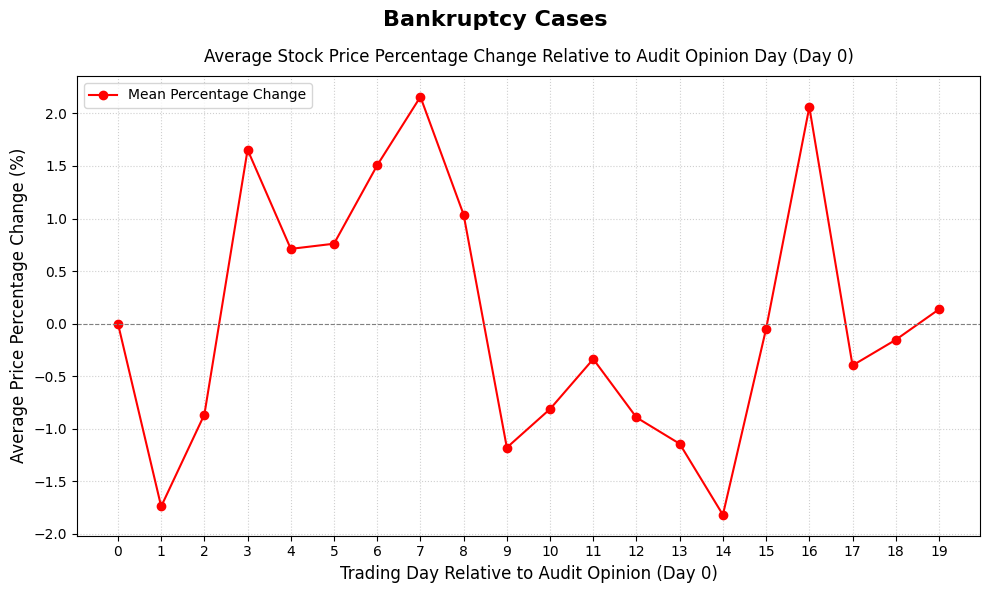

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import re

result_copy=result[:76].copy()
# --- Plotting Logic ---

# 1. Identify relevant change columns
change_cols = [col for col in result_copy.columns if re.match(r'Day_\d+_Change', col)]

# 2. Add Day 0 (issuing of the audit opinion) with 0% change
result_copy['Day_0_Change'] = 0.0
change_cols.insert(0, 'Day_0_Change') # Insert at the start

# 3. Reshape the data (Melt from wide to long format)
df_melted = result_copy[change_cols].melt(
    value_vars=change_cols,
    var_name='Time',
    value_name='Price_Change'
)

# 4. Extract the day number (0 to 19)
df_melted['Day'] = df_melted['Time'].str.extract(r'Day_(\d+)_Change').astype(int)
df_melted = df_melted.sort_values(by='Day')

# 5. Calculate the mean percentage change for each day
df_mean_change = df_melted.groupby('Day')['Price_Change'].mean().reset_index()

# 6. Plotting
plt.figure(figsize=(10, 6))

# Plot the mean line
plt.plot(
    df_mean_change['Day'],
    df_mean_change['Price_Change'],
    marker='o',
    linestyle='-',
    color='red',
    label='Mean Percentage Change'
)

# Add a horizontal line at 0%
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)

# Customize the plot
# 1. Main Title (The Subject)
plt.suptitle('Bankruptcy Cases', 
             fontsize=16, 
             fontweight='bold') # y=1.02 slightly lifts the title above the plot area

# 2. Subtitle (The Description)
plt.title('Average Stock Price Percentage Change Relative to Audit Opinion Day (Day 0)', 
          fontsize=12, 
          pad=10) 
plt.ylabel('Average Price Percentage Change (%)', fontsize=12)
plt.xlabel('Trading Day Relative to Audit Opinion (Day 0)', fontsize=12)
plt.xticks(df_mean_change['Day'])
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig('average_price_change_diagram_bankruptcy.png')

print("The chart has been successfully created and saved as 'average_price_change_diagram_bankruptcy.png'.")

### THE NON BANKRUPCTY CASES DESCRIBE

In [35]:
result[75:].describe()

,Zero,Day_1_Change,Day_2_Change,Day_3_Change,Day_4_Change,Day_5_Change,Day_6_Change,Day_7_Change,Day_8_Change,Day_9_Change,Day_10_Change,Day_11_Change,Day_12_Change,Day_13_Change,Day_14_Change,Day_15_Change,Day_16_Change,Day_17_Change,Day_18_Change,Day_19_Change
count,1014.0,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,0.0,-0.085133,-0.488515,-0.853817,-1.875819,-2.285745,-3.006501,-4.106880,-4.950823,-5.529016,-6.274539,-7.410284,-7.858168,-9.023711,-9.031934,-8.861497,-8.880471,-6.510875,-7.332669,-7.429624
std,0.0,6.559172,9.267191,11.402215,15.250063,18.538291,21.962754,23.213161,23.643153,26.989810,29.651202,31.208288,32.432752,31.445878,35.231216,42.107519,40.694751,74.752904,58.813876,58.121547
min,0.0,-35.209424,-73.493976,-85.662651,-87.951807,-89.108434,-89.397590,-86.674699,-88.554217,-86.746988,-85.903614,-87.628827,-90.000000,-83.783133,-85.542169,-88.674699,-88.385542,-88.240964,-89.879518,-90.096386
25%,0.0,-2.559759,-3.966374,-5.630048,-7.890370,-9.462130,-10.733452,-13.064449,-15.417240,-16.976163,-18.959070,-21.014511,-22.458509,-25.074984,-27.024258,-29.028881,-29.817720,-29.311336,-28.656194,-28.830649
50%,0.0,0.000000,-0.732208,-1.293473,-1.950575,-2.661962,-3.798166,-4.482109,-5.200333,-6.011294,-6.666754,-7.184726,-7.625200,-8.367631,-8.586233,-9.800620,-10.317688,-10.435032,-11.750354,-11.269693
75%,0.0,1.659701,1.834590,1.949946,1.554920,1.761264,1.657926,1.514251,1.788008,1.366342,1.427488,1.602239,2.133648,2.076562,2.236957,2.090708,2.628286,3.224777,3.528469,3.590625
max,0.0,66.666590,95.555607,97.169331,225.641026,305.102564,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,268.571429,387.500000,712.500000,500.000000,2010.000000,1400.000000,1400.000000


The chart has been successfully created and saved as 'average_price_change_diagram_non_bankruptcy.png'.


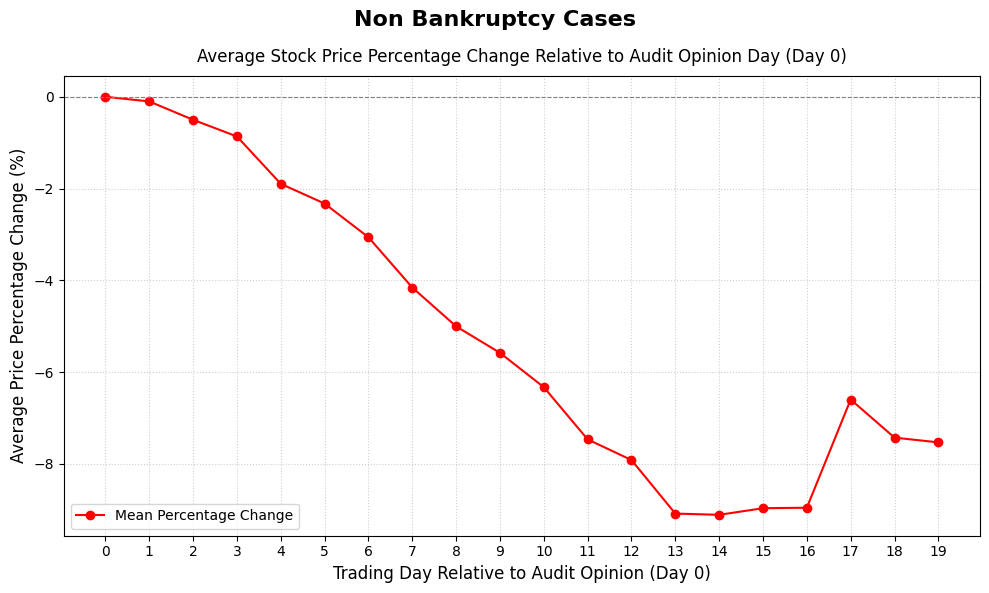

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import re

result_copy=result[76:].copy()
# --- Plotting Logic ---

# 1. Identify relevant change columns
change_cols = [col for col in result_copy.columns if re.match(r'Day_\d+_Change', col)]

# 2. Add Day 0 (issuing of the audit opinion) with 0% change
result_copy['Day_0_Change'] = 0.0
change_cols.insert(0, 'Day_0_Change') # Insert at the start

# 3. Reshape the data (Melt from wide to long format)
df_melted = result_copy[change_cols].melt(
    value_vars=change_cols,
    var_name='Time',
    value_name='Price_Change'
)

# 4. Extract the day number (0 to 19)
df_melted['Day'] = df_melted['Time'].str.extract(r'Day_(\d+)_Change').astype(int)
df_melted = df_melted.sort_values(by='Day')

# 5. Calculate the mean percentage change for each day
df_mean_change = df_melted.groupby('Day')['Price_Change'].mean().reset_index()

# 6. Plotting
plt.figure(figsize=(10, 6))

# Plot the mean line
plt.plot(
    df_mean_change['Day'],
    df_mean_change['Price_Change'],
    marker='o',
    linestyle='-',
    color='red',
    label='Mean Percentage Change'
)

# Add a horizontal line at 0%
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)

# Customize the plot
# 1. Main Title (The Subject)
plt.suptitle('Non Bankruptcy Cases', 
             fontsize=16, 
             fontweight='bold') # y=1.02 slightly lifts the title above the plot area

# 2. Subtitle (The Description)
plt.title('Average Stock Price Percentage Change Relative to Audit Opinion Day (Day 0)', 
          fontsize=12, 
          pad=10) 
plt.ylabel('Average Price Percentage Change (%)', fontsize=12)
plt.xlabel('Trading Day Relative to Audit Opinion (Day 0)', fontsize=12)
plt.xticks(df_mean_change['Day'])
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig('average_price_change_diagram_non_bankruptcy.png')

print("The chart has been successfully created and saved as 'average_price_change_diagram_non_bankruptcy.png'.")

### RESULTS 

In [37]:
result.describe()

,Zero,Day_1_Change,Day_2_Change,Day_3_Change,Day_4_Change,Day_5_Change,Day_6_Change,Day_7_Change,Day_8_Change,Day_9_Change,Day_10_Change,Day_11_Change,Day_12_Change,Day_13_Change,Day_14_Change,Day_15_Change,Day_16_Change,Day_17_Change,Day_18_Change,Day_19_Change
count,1089.0,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,0.0,-0.215319,-0.526939,-0.688316,-1.714504,-2.111716,-2.742401,-3.715686,-4.581266,-5.272860,-5.942875,-6.968678,-7.425970,-8.528714,-8.601038,-8.343539,-8.186305,-6.164592,-6.920063,-6.995933
std,0.0,7.307857,9.944346,13.742459,16.493327,19.662429,23.110247,25.216489,25.219820,27.787731,30.310760,31.862690,33.459471,32.615891,35.840986,42.844147,42.889232,73.611019,58.349842,57.952616
min,0.0,-45.714239,-73.493976,-85.662651,-87.951807,-89.108434,-89.397590,-86.674699,-88.554217,-86.746988,-85.903614,-87.628827,-90.000000,-83.783133,-85.542169,-88.674699,-88.385542,-88.240964,-89.879518,-90.096386
25%,0.0,-2.717631,-4.176117,-5.763415,-8.201655,-9.563226,-10.967312,-13.125186,-15.458258,-17.211094,-19.143419,-21.054835,-22.540818,-25.528431,-27.220856,-28.859474,-29.508197,-29.298632,-28.570009,-28.864079
50%,0.0,0.000000,-0.749971,-1.273029,-1.915709,-2.789773,-3.703704,-4.412016,-5.103953,-5.797101,-6.344411,-7.008672,-7.500000,-8.218836,-8.484848,-9.783603,-10.007524,-10.449996,-11.439114,-11.111111
75%,0.0,1.688496,1.929852,2.073113,1.636536,1.862692,1.774226,1.949956,2.252656,1.839080,1.757853,1.951773,2.323565,2.369390,2.523874,2.538875,2.813040,3.333333,3.584841,3.692862
max,0.0,66.666590,95.555607,210.000000,225.641026,305.102564,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,268.571429,387.500000,712.500000,500.000000,2010.000000,1400.000000,1400.000000


The chart has been successfully created and saved as 'average_price_change_diagram.png'.


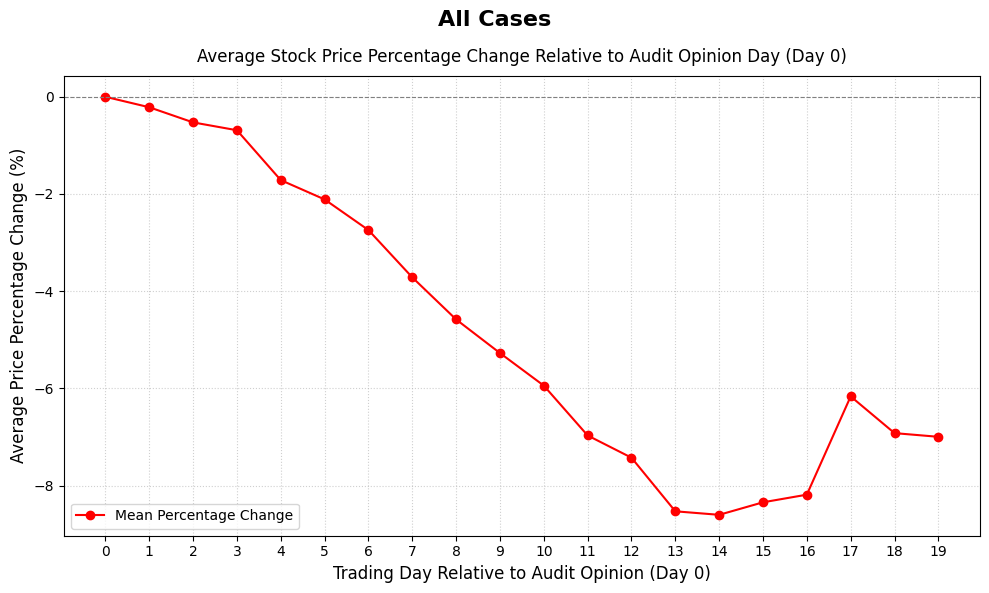

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import re

result_copy=result.copy()
# --- Plotting Logic ---

# 1. Identify relevant change columns
change_cols = [col for col in result_copy.columns if re.match(r'Day_\d+_Change', col)]

# 2. Add Day 0 (issuing of the audit opinion) with 0% change
result_copy['Day_0_Change'] = 0.0
change_cols.insert(0, 'Day_0_Change') # Insert at the start

# 3. Reshape the data (Melt from wide to long format)
df_melted = result_copy[change_cols].melt(
    value_vars=change_cols,
    var_name='Time',
    value_name='Price_Change'
)

# 4. Extract the day number (0 to 19)
df_melted['Day'] = df_melted['Time'].str.extract(r'Day_(\d+)_Change').astype(int)
df_melted = df_melted.sort_values(by='Day')

# 5. Calculate the mean percentage change for each day
df_mean_change = df_melted.groupby('Day')['Price_Change'].mean().reset_index()

# 6. Plotting
plt.figure(figsize=(10, 6))

# Plot the mean line
plt.plot(
    df_mean_change['Day'],
    df_mean_change['Price_Change'],
    marker='o',
    linestyle='-',
    color='red',
    label='Mean Percentage Change'
)

# Add a horizontal line at 0%
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)

# Customize the plot
plt.suptitle('All Cases', 
             fontsize=16, 
             fontweight='bold') # y=1.02 slightly lifts the title above the plot area

# 2. Subtitle (The Description)
plt.title('Average Stock Price Percentage Change Relative to Audit Opinion Day (Day 0)', 
          fontsize=12, 
          pad=10) 
plt.xlabel('Trading Day Relative to Audit Opinion (Day 0)', fontsize=12)
plt.ylabel('Average Price Percentage Change (%)', fontsize=12)
plt.xticks(df_mean_change['Day'])
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig('average_price_change_diagram.png')

print("The chart has been successfully created and saved as 'average_price_change_diagram.png'.")

In [39]:
result.columns

Index(['cik', 'year_from_filename', 'Start_Date', 'Zero', 'Day_1_Date',
       'Day_1_Change', 'Day_2_Date', 'Day_2_Change', 'Day_3_Date',
       'Day_3_Change', 'Day_4_Date', 'Day_4_Change', 'Day_5_Date',
       'Day_5_Change', 'Day_6_Date', 'Day_6_Change', 'Day_7_Date',
       'Day_7_Change', 'Day_8_Date', 'Day_8_Change', 'Day_9_Date',
       'Day_9_Change', 'Day_10_Date', 'Day_10_Change', 'Day_11_Date',
       'Day_11_Change', 'Day_12_Date', 'Day_12_Change', 'Day_13_Date',
       'Day_13_Change', 'Day_14_Date', 'Day_14_Change', 'Day_15_Date',
       'Day_15_Change', 'Day_16_Date', 'Day_16_Change', 'Day_17_Date',
       'Day_17_Change', 'Day_18_Date', 'Day_18_Change', 'Day_19_Date',
       'Day_19_Change'],
      dtype='object')

In [40]:
result_dfs = {}

# Loop through Day_1 to Day_19
for i in range(1, 20):
    df_i = result[['Start_Date', 
                   f'Day_{i}_Date', 
                   f'Day_{i}_Change', 
                   'cik', 
                   'year_from_filename']].copy()
    
    # Rename columns consistently
    df_i.columns = ['Start_Date', f'Day_{i}_Date', f'Day_{i}_Change', 'cik', 'year_from_filename']
    
    # Save into dict
    result_dfs[f'result_{i}'] = df_i

# Example: access result_14
result_1 = result_dfs['result_1']
result_1.tail(50)

,Start_Date,Day_1_Date,Day_1_Change,cik,year_from_filename
1039,24/2/2020,25/2/2020,-3.353838,1535929,2019
1040,1/4/2002,2/4/2002,-0.456453,1045309,2001
1041,8/3/2005,9/3/2005,-0.208039,1045309,2004
1042,3/3/2017,6/3/2017,-1.718046,1288403,2016
1043,15/4/2009,16/4/2009,3.596529,879526,2008
1044,24/2/2020,25/2/2020,-0.140066,1390844,2019
1045,2/3/2012,5/3/2012,0.000000,1144686,2010
1046,26/2/2020,27/2/2020,-1.971302,737468,2019
1047,25/2/2003,26/2/2003,-0.299829,823768,2002
1048,14/2/2020,18/2/2020,0.373842,823768,2019


In [41]:
import pandas as pd
import numpy as np

# Adjustable parameters
initial_capital = 100_000
trade_fraction_grid = np.arange(0.005, 0.045, 0.005)  # 0.005 to 0.04 inclusive
predictors = ['pred_best', 'pred_2nd', 'pred_3rd','pred_4th']

summary_records = []
timelines_dict = {}  # Store full timeline per grid combination

for day_idx, day_name in enumerate(result_dfs.keys(), start=1):
    df_day = result_dfs[day_name].copy()
    
    # Normalize keys safely using .loc to avoid warnings
    df_day.loc[:, 'cik'] = df_day['cik'].astype(str).str.strip()
    df_day.loc[:, 'year_from_filename'] = pd.to_numeric(df_day['year_from_filename'], errors='coerce')
    
    # Merge predictions
    df_day_merged = df_day.merge(
        df_unified[['year','firm_id','pred_best','pred_2nd','pred_3rd','pred_4th']],
        left_on=['year_from_filename','cik'],
        right_on=['year','firm_id'],
        how='left'
    ).drop(columns=['year','firm_id'])
    
    for predictor in predictors:
        test_df = df_day_merged[df_day_merged[predictor]==1].copy()
        if test_df.empty:
            continue
        
        for trade_fraction in trade_fraction_grid:
            # --- Portfolio simulation ---
            portfolio = initial_capital
            min_capital = portfolio
            max_capital = portfolio
            open_trades = {}
            timeline = []
            bankruptcy_date = None
            
            test_df.loc[:, 'Start_Date_dt'] = pd.to_datetime(test_df['Start_Date'], dayfirst=True, errors='coerce')
            test_df.loc[:, 'End_Date_dt'] = pd.to_datetime(test_df[f'Day_{day_idx}_Date'], dayfirst=True, errors='coerce')
            test_df.loc[:, 'Change_pct'] = pd.to_numeric(test_df[f'Day_{day_idx}_Change'], errors='coerce')
            test_df = test_df.dropna(subset=['Start_Date_dt','End_Date_dt','Change_pct']).reset_index(drop=True)
            
            # Build event list
            events = []
            for trade_id, row in test_df.iterrows():
                events.append({'date': row['Start_Date_dt'], 'type':'start','trade_id':trade_id,'change_pct':row['Change_pct'],'end_date':row['End_Date_dt']})
                events.append({'date': row['End_Date_dt'], 'type':'end','trade_id':trade_id,'change_pct':row['Change_pct'],'start_date':row['Start_Date_dt']})
            
            events = pd.DataFrame(events).sort_values('date').reset_index(drop=True)
            
            # Simulate portfolio
            for _, ev in events.iterrows():
                if ev['type']=='start':
                    trade_value = portfolio * trade_fraction
                    open_trades[ev['trade_id']] = {'trade_value':trade_value, 'change_pct':ev['change_pct']}
                    timeline.append({
                        'date': ev['date'],
                        'event': 'OPEN',
                        'trade_id': ev['trade_id'],
                        'trade_value': trade_value,
                        'portfolio': portfolio,
                        'open_trades_count': len(open_trades)
                    })
                    
                elif ev['type']=='end':
                    trade = open_trades.pop(ev['trade_id'], None)
                    if trade:
                        actual_pnl = - (trade['change_pct']/100) * trade['trade_value']
                        portfolio += actual_pnl
                        theoretical_pnl = - (trade['change_pct']/100) * (initial_capital * trade_fraction)
                        timeline.append({
                            'date': ev['date'],
                            'event': 'CLOSE',
                            'trade_id': ev['trade_id'],
                            'trade_value': trade['trade_value'],
                            'pct_change': trade['change_pct'],
                            'actual_pnl': actual_pnl,
                            'theoretical_pnl': theoretical_pnl,
                            'portfolio': portfolio,
                            'open_trades_count': len(open_trades)
                        })
                        min_capital = min(min_capital, portfolio)
                        max_capital = max(max_capital, portfolio)
                        if portfolio <= 0 and bankruptcy_date is None:
                            bankruptcy_date = ev['date']
                            print(f"Bankruptcy on Day {day_idx}, predictor {predictor}, trade_fraction {trade_fraction}, date {bankruptcy_date}")
            
            # Store timeline
            timeline_df = pd.DataFrame(timeline)
            timelines_dict[(day_idx, predictor, trade_fraction)] = timeline_df
            
            # Compute PnL extremes
            actual_pnls = timeline_df['actual_pnl'].dropna() if not timeline_df.empty else pd.Series(dtype=float)
            
            # --- Print real-time summary ---
            print(f"Day {day_idx}, Predictor {predictor}, Trade fraction {trade_fraction:.3f}")
            print(f"Min capital: {min_capital:.2f}, Max capital: {max_capital:.2f}, Max concurrent trades: {timeline_df['open_trades_count'].max() if not timeline_df.empty else 0}")
            print(f"Min actual PnL: {actual_pnls.min() if not actual_pnls.empty else 0:.2f}, Max actual PnL: {actual_pnls.max() if not actual_pnls.empty else 0:.2f}")
            print(f"Final capital: {portfolio:.2f}, Bankruptcy date: {bankruptcy_date}")
            print("-"*70)
            
            # Store summary
            summary_records.append({
                'day': day_idx,
                'predictor': predictor,
                'trade_fraction': trade_fraction,
                'min_capital': min_capital,
                'max_capital': max_capital,
                'max_concurrent_trades': timeline_df['open_trades_count'].max() if not timeline_df.empty else 0,
                'min_actual_pnl': actual_pnls.min() if not actual_pnls.empty else 0,
                'max_actual_pnl': actual_pnls.max() if not actual_pnls.empty else 0,
                'final_capital': portfolio,
                'bankruptcy_date': bankruptcy_date
            })

# Convert summary to DataFrame
summary_df = pd.DataFrame(summary_records)


Day 1, Predictor pred_best, Trade fraction 0.005
Min capital: 99048.50, Max capital: 100136.66, Max concurrent trades: 9
Min actual PnL: -249.77, Max actual PnL: 227.79
Final capital: 100010.14, Bankruptcy date: None
----------------------------------------------------------------------
Day 1, Predictor pred_best, Trade fraction 0.010
Min capital: 98102.59, Max capital: 100271.80, Max concurrent trades: 9
Min actual PnL: -499.08, Max actual PnL: 454.02
Final capital: 100014.31, Bankruptcy date: None
----------------------------------------------------------------------
Day 1, Predictor pred_best, Trade fraction 0.015
Min capital: 97162.26, Max capital: 100405.43, Max concurrent trades: 9
Min actual PnL: -747.94, Max actual PnL: 678.70
Final capital: 100012.52, Bankruptcy date: None
----------------------------------------------------------------------
Day 1, Predictor pred_best, Trade fraction 0.020
Min capital: 96227.54, Max capital: 100537.54, Max concurrent trades: 9
Min actual PnL:

In [42]:
summary_sorted_final = summary_df.sort_values(by='final_capital', ascending=False).reset_index(drop=True)
summary_sorted_final['exposure_fraction'] = summary_sorted_final['trade_fraction'] * summary_sorted_final['max_concurrent_trades']

# Display relevant columns


summary_sorted_final[['day', 'predictor', 'trade_fraction', 'min_capital','exposure_fraction',
       'max_concurrent_trades', 
       'final_capital']]

,day,predictor,trade_fraction,min_capital,exposure_fraction,max_concurrent_trades,final_capital
0,16,pred_4th,0.040,74161.095036,15.120,378,456518.298959
1,15,pred_4th,0.040,70614.394113,14.880,372,430785.635757
2,16,pred_4th,0.035,77206.940208,13.230,378,424015.565058
3,13,pred_4th,0.040,76826.945036,14.400,360,412869.417502
4,14,pred_4th,0.040,71542.531329,14.720,368,411127.532243
5,15,pred_4th,0.035,74020.507068,13.020,372,402236.739652
6,16,pred_4th,0.030,80308.376908,11.340,378,388137.996160
7,14,pred_4th,0.035,74854.601177,12.880,368,384249.131916
8,13,pred_4th,0.035,79607.967433,12.600,360,383445.669539
9,12,pred_4th,0.040,76778.244296,14.160,354,380963.827762


In [43]:
final_df=summary_sorted_final[['day', 'predictor', 'trade_fraction', 'min_capital','exposure_fraction',
       'max_concurrent_trades', 
       'final_capital']].copy()
final_df[(final_df['min_capital']>70000) &(final_df['exposure_fraction']<6)&(final_df['final_capital']>150000)].head(18)


,day,predictor,trade_fraction,min_capital,exposure_fraction,max_concurrent_trades,final_capital
66,16,pred_4th,0.015,89931.697494,5.670,378,259833.267873
76,15,pred_4th,0.015,88424.389889,5.580,372,251914.627654
83,14,pred_4th,0.015,88818.900547,5.520,368,242957.270959
89,13,pred_4th,0.015,91076.186278,5.400,360,238165.049964
93,15,pred_3rd,0.015,81913.340141,5.730,382,231907.689713
95,14,pred_3rd,0.015,84118.219746,5.685,379,229754.964916
96,5,pred_4th,0.030,97197.370771,5.790,193,228548.813698
101,13,pred_3rd,0.015,85588.665452,5.535,369,225432.106891
102,16,pred_3rd,0.015,77715.190859,5.835,389,224671.428065
103,12,pred_4th,0.015,91204.900951,5.310,354,222900.488334


In [46]:
final_df[(final_df['min_capital']>70000) &(final_df['exposure_fraction']<6)&(final_df['final_capital']>150000)]

,day,predictor,trade_fraction,min_capital,exposure_fraction,max_concurrent_trades,final_capital
66,16,pred_4th,0.015,89931.697494,5.670,378,259833.267873
76,15,pred_4th,0.015,88424.389889,5.580,372,251914.627654
83,14,pred_4th,0.015,88818.900547,5.520,368,242957.270959
89,13,pred_4th,0.015,91076.186278,5.400,360,238165.049964
93,15,pred_3rd,0.015,81913.340141,5.730,382,231907.689713
95,14,pred_3rd,0.015,84118.219746,5.685,379,229754.964916
96,5,pred_4th,0.030,97197.370771,5.790,193,228548.813698
101,13,pred_3rd,0.015,85588.665452,5.535,369,225432.106891
102,16,pred_3rd,0.015,77715.190859,5.835,389,224671.428065
103,12,pred_4th,0.015,91204.900951,5.310,354,222900.488334


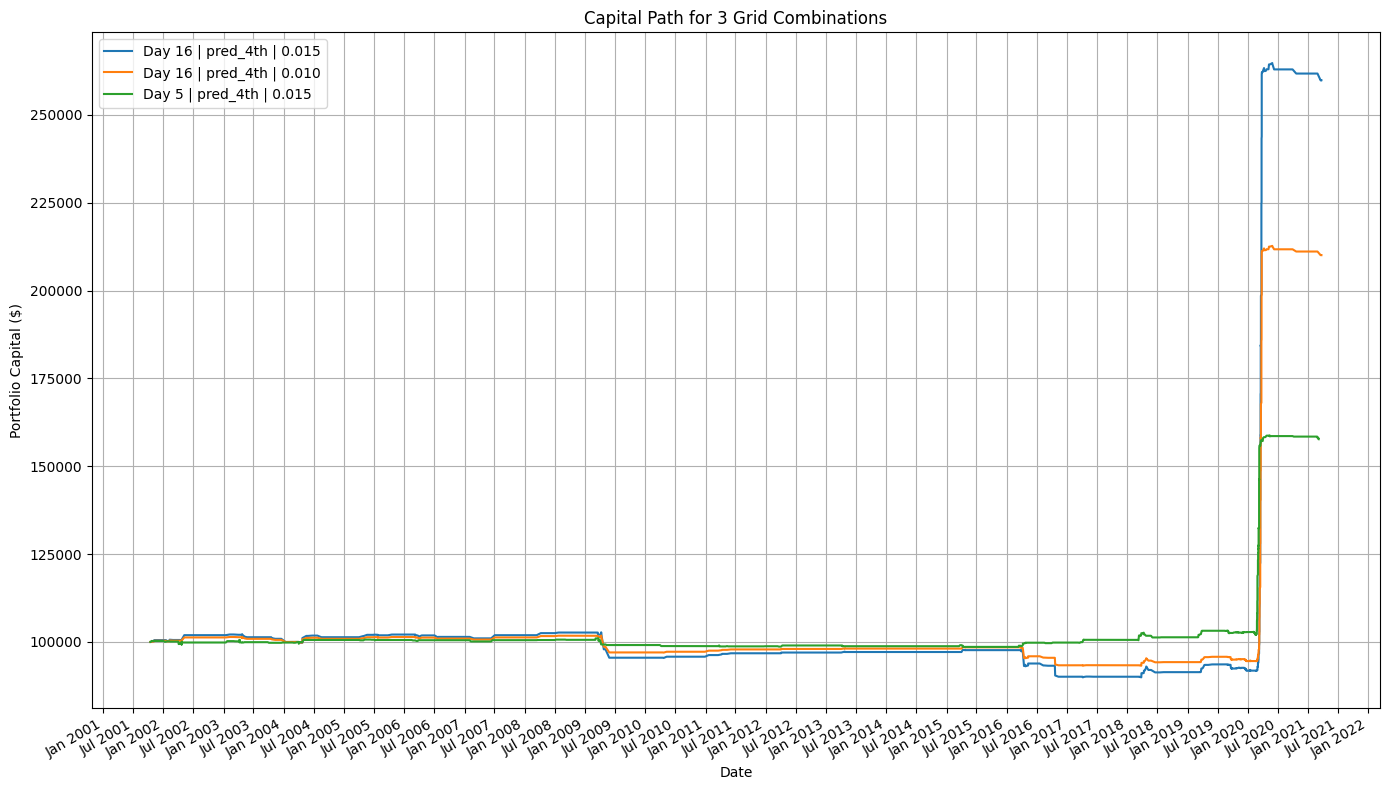

In [47]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Import the dates module

# Define the top 4 pairs (based on nuanced criteria)
top4_pairs = [
    (16, 'pred_4th', 0.015),
    (16, 'pred_4th', 0.01),
    (5, 'pred_4th', 0.015)
]

# Assuming 'timelines_dict' is defined and contains dataframes

plt.figure(figsize=(14, 8))
ax = plt.gca() # Get the current Axes instance

for day, predictor, trade_fraction in top4_pairs:
    timeline_df = timelines_dict.get((day, predictor, trade_fraction))
    if timeline_df is not None and not timeline_df.empty:
        # Ensure the 'date' column is in datetime format if it's not already
        # (This is a good practice, though not strictly necessary if it's already plottable)
        # timeline_df['date'] = pd.to_datetime(timeline_df['date']) 
        plt.plot(timeline_df['date'], timeline_df['portfolio'], label=f'Day {day} | {predictor} | {trade_fraction:.3f}')

# --- Customizing X-Axis Ticks ---

# 1. Set the major tick locator to show ticks every six months (January=1, July=7)
# Use 'interval=6' or 'bymonth=(1, 7)' for six-month intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7))) 

# 2. Set the formatter for the date labels
# '%b' is the abbreviated month name (e.g., Jan), '%Y' is the 4-digit year (e.g., 2007)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 

# 3. Rotate and align the x-axis labels for better readability (optional but recommended for dates)
plt.gcf().autofmt_xdate()

# --- Original Plot Settings ---

plt.title("Capital Path for 3 Grid Combinations")
plt.xlabel("Date")
plt.ylabel("Portfolio Capital ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

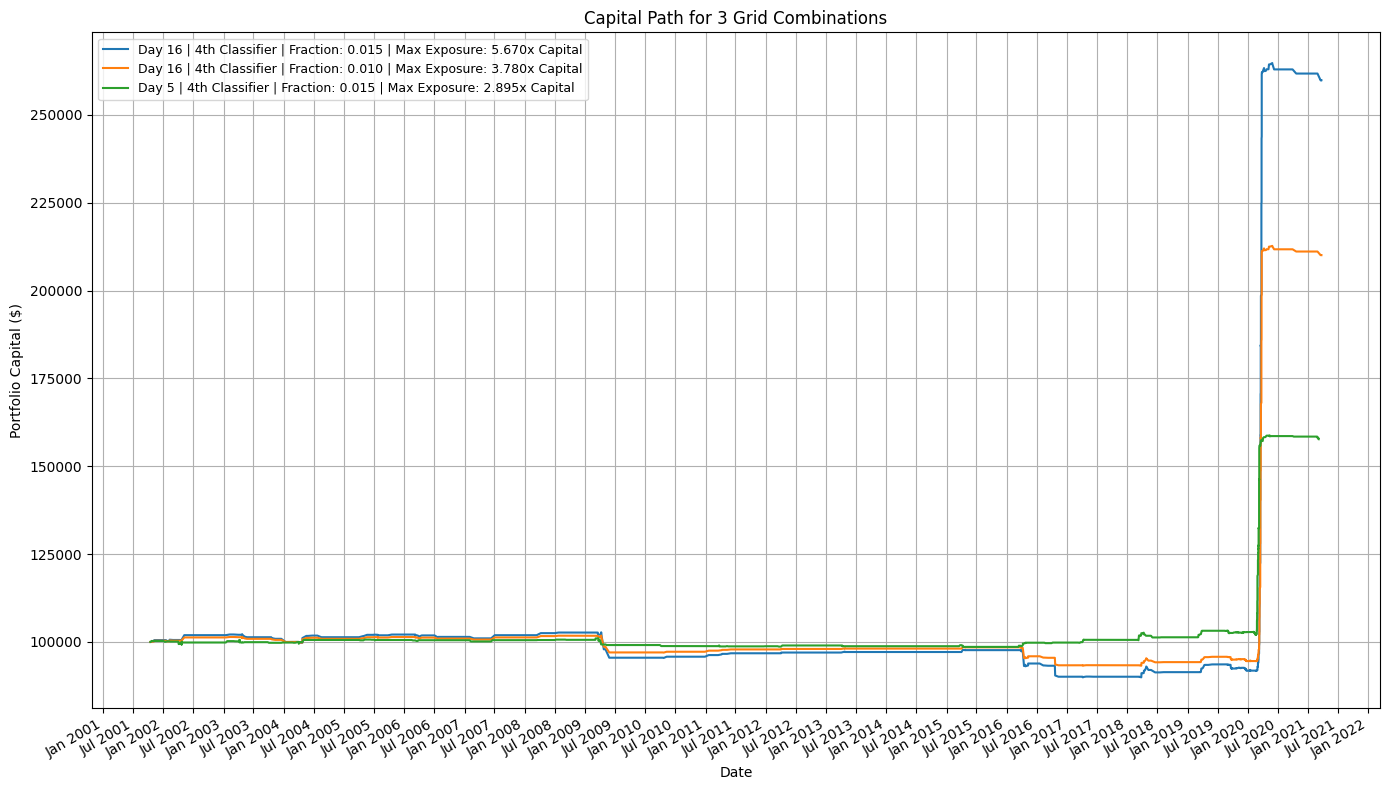

In [48]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

# Define the top 4 pairs (based on nuanced criteria)
top4_pairs = [
    (16, 'pred_4th', 0.015),
    (16, 'pred_4th', 0.01),
    (5, 'pred_4th', 0.015)
]

# 1. Define the Maximum Capital Mapping
# The key is a tuple: (day, predictor, trade_fraction)
max_capital_map = {
    (16, 'pred_4th', 0.015): '5.670x Capital',
    (16, 'pred_4th', 0.01): '3.780x Capital',
    (5, 'pred_4th', 0.015): '2.895x Capital'
}

# 2. Define the Predictor Name Mapping
predictor_map = {
    'pred_4th': '4th Classifier',
    # Add other mappings if needed, e.g., 'pred_1st': '1st Classifier'
}


# Assuming 'timelines_dict' is defined and contains dataframes
# --- START of Plotting Code ---

plt.figure(figsize=(14, 8))
ax = plt.gca() # Get the current Axes instance

for day, predictor_key, trade_fraction in top4_pairs:
    # 3. Retrieve the full key and mappings for the current iteration
    pair_key = (day, predictor_key, trade_fraction)
    
    # Get the descriptive names from the maps
    max_capital_label = max_capital_map.get(pair_key, 'N/A')
    predictor_label = predictor_map.get(predictor_key, predictor_key) # Default to key if not found
    
    timeline_df = timelines_dict.get(pair_key)
    
    if timeline_df is not None and not timeline_df.empty:
        # 4. Construct the new, detailed label string
        new_label = (
            f'Day {day} | {predictor_label} | Fraction: {trade_fraction:.3f} | Max Exposure: {max_capital_label}'
        )
        
        plt.plot(timeline_df['date'], timeline_df['portfolio'], label=new_label)

# --- Customizing X-Axis Ticks (Original) ---

# 1. Set the major tick locator to show ticks every six months (January=1, July=7)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))  

# 2. Set the formatter for the date labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  

# 3. Rotate and align the x-axis labels for better readability
plt.gcf().autofmt_xdate()

# --- Original Plot Settings ---

plt.title("Capital Path for 3 Grid Combinations")
plt.xlabel("Date")
plt.ylabel("Portfolio Capital ($)")
plt.legend(loc='upper left', fontsize=9) # Adjusted legend settings slightly for better fit
plt.grid(True)
plt.tight_layout()
plt.savefig('capital_path_grid_combinations.png') 
plt.show()